# Sports Analytics V2

## Importing necessary libraries and modules for the program

In [77]:
import pandas as pd
import numpy as np
import re
import csv

import nltk
nltk.download('vader_lexicon')
words = set(nltk.corpus.words.words())
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from transformers import pipeline
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
from scipy.special import softmax

import seaborn as sns
import matplotlib.pyplot as plt

import datetime as dt
from datetime import datetime
import time

import urllib.request
import requests


from types import SimpleNamespace

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, auc, roc_curve
from sklearn import svm, model_selection, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, \
    gaussian_process
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM



import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
import joblib


import keras
import tensorflow as tf



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/rubenmaharjan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## TWITTER API 

In [4]:
def bearer_oauth(r):
    """
    Method required by bearer token authentication.
    """
    bearer_token ='' # Token not added in the file.
    r.headers["Authorization"] = f"Bearer {bearer_token}"
    r.headers["User-Agent"] = "v2FullArchiveSearchPython"
    return r

## Functions to fetch tweets

In [7]:
def connect_to_endpoint(url, params):
    response = requests.request("GET", url, auth=bearer_oauth, params=params)
    if response.status_code != 200:
        if response.status_code == 503 or response.status_code == 429:
            time.sleep(200)
            connect_to_endpoint(url, params)
        else:
            raise Exception(response.status_code, response.text)

    return response.json()


def search_tweets(keyword, start_date, end_date, max_results = 500):
    
    search_url = "https://api.twitter.com/2/tweets/search/all" 
    #change params based on the endpoint you are using
    query_params = {'query': keyword,
                    'start_time': start_date,
                    'end_time': end_date,
                    'max_results': max_results,
                    'expansions': 'author_id,in_reply_to_user_id,geo.place_id',
#                     'tweet.fields': 'id,text,author_id,in_reply_to_user_id,geo,conversation_id,created_at,lang,public_metrics,referenced_tweets,reply_settings,source',
                    'user.fields': 'id,name,username,created_at,description,public_metrics,verified',
                    'place.fields': 'full_name,id,country,country_code,geo,name,place_type',
                    'next_token': {}}
    return (search_url, query_params)

def count_tweets(keyword, start_date, end_date):
    
    count_url = "https://api.twitter.com/2/tweets/counts/all"

    #change params based on the endpoint you are using
    query_params = {'query': keyword,
                    'start_time': start_date,
                    'end_time': end_date,
                    }
    return (count_url, query_params)

def clean_text(tweet):
    tweet = re.sub("@[A-Za-z0-9]+","",tweet) #Remove @ sign
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) #Remove http links
    tweet = " ".join(tweet.split())
    tweet = tweet.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    tweet = " ".join(w for w in nltk.wordpunct_tokenize(tweet) \
         if w.lower() in words or not w.isalpha())
    return tweet

def decrease_kickoff(date):
    return (datetime.strptime(date, "%Y-%m-%dT%H:%M:%SZ") - dt.timedelta(minutes=60)).strftime("%Y-%m-%dT%H:%M:%SZ")

def player_query_creator(data, lang:str='en', include_retweet:bool=False):
    name = data.name
    name = ' OR '.join(name.split(' '))
    query = f'({name}) ({data.matchday_hashtag} OR #{data.team_h_short_name} OR #{data.tema_a_short_name}) lang:{lang}'
    if not include_retweet:
        query += ' -is:retweet'
    return query

def tema_query_creator(data, lang:str='en', include_retweet:bool=False):
    query = f'({data.matchday_hashtag} OR #{data.team_h_short_name} OR #{data.team_a_short_name}) lang:{lang}'
    if not include_retweet:
        query += ' -is:retweet'
    return query

def team_query_creator_single(short_name, name, lang:str='en', include_retweet:bool=False):
    query = f'(#{short_name} OR #{name}) lang:{lang}'
    if not include_retweet:
        query += ' -is:retweet'
    return query

# Get the GameWeek Infromation

In [8]:
def get_gameweek_info(fixture_path:str, teams_path:str):
    fixtures_df = pd.read_csv(fixture_path)
    fixtures_df['event'].fillna(0, inplace=True)
    fixtures_df = fixtures_df.astype({'event': int})

    # Get the gameweek hastag and team names
    teams_df = pd.read_csv(teams_path)
    teams_dict = pd.Series(teams_df.name.values,index=teams_df.id).to_dict()
    teams_short_dict = pd.Series(teams_df.short_name.values,index=teams_df.id).to_dict()

    fixtures_df['team_a_name'] = fixtures_df['team_a'].map(teams_dict)
    fixtures_df['team_h_name'] = fixtures_df['team_h'].map(teams_dict)
    fixtures_df['team_a_short_name'] = fixtures_df['team_a'].map(teams_short_dict)
    fixtures_df['team_h_short_name'] = fixtures_df['team_h'].map(teams_short_dict)
    fixtures_df['matchday_hashtag'] = "#"+fixtures_df['team_h_short_name']+fixtures_df['team_a_short_name']

    #Add Start Time and End Time
    fixtures_df['end_time'] = fixtures_df['kickoff_time'].apply(decrease_kickoff)
    start_time_dict = fixtures_df.groupby('event').last()[['kickoff_time']].to_dict()['kickoff_time']
    start_time_dict = {k+1:v for k,v in start_time_dict.items()}

    # First start time is the time one week before the first kickoff
    first_kick_off = fixtures_df.groupby('event').first()[['kickoff_time']].to_dict()['kickoff_time'][1]
    d = datetime.strptime(first_kick_off, "%Y-%m-%dT%H:%M:%SZ")
    start_time_dict[1] = (d - dt.timedelta(days=7)).strftime("%Y-%m-%dT%H:%M:%SZ")
    fixtures_df['start_time'] = fixtures_df['event'].map(start_time_dict)

    return fixtures_df

In [9]:
fixture_file_path = "data/fixtures.csv"
teams_file_path = "data/teams.csv"
fixtures_df = get_gameweek_info(fixture_file_path, teams_file_path)
fixtures_df.head()

,code,event,finished,finished_provisional,id,kickoff_time,minutes,provisional_start_time,started,team_a,...,team_h_difficulty,team_a_difficulty,pulse_id,team_a_name,team_h_name,team_a_short_name,team_h_short_name,matchday_hashtag,end_time,start_time
0,2128288,1,True,True,2,2020-09-12T11:30:00Z,90,False,True,1,...,3,2,58898,Arsenal,Fulham,ARS,FUL,#FULARS,2020-09-12T10:30:00Z,2020-09-05T11:30:00Z
1,2128287,1,True,True,1,2020-09-12T14:00:00Z,90,False,True,16,...,2,3,58897,Southampton,Crystal Palace,SOU,CRY,#CRYSOU,2020-09-12T13:00:00Z,2020-09-05T11:30:00Z
2,2128289,1,True,True,3,2020-09-12T16:30:00Z,90,False,True,10,...,3,3,58899,Leeds,Liverpool,LEE,LIV,#LIVLEE,2020-09-12T15:30:00Z,2020-09-05T11:30:00Z
3,2128293,1,True,True,6,2020-09-12T19:00:00Z,90,False,True,14,...,2,4,58903,Newcastle,West Ham,NEW,WHU,#WHUNEW,2020-09-12T18:00:00Z,2020-09-05T11:30:00Z
4,2128292,1,True,True,5,2020-09-13T13:00:00Z,90,False,True,9,...,4,2,58902,Leicester,West Brom,LEI,WBA,#WBALEI,2020-09-13T12:00:00Z,2020-09-05T11:30:00Z


## Merging Infos

In [10]:
fixtures_df_clean = fixtures_df[['event', 'finished', 'team_a_name', 'team_h_name',	'team_a_short_name', 'team_h_short_name', 'matchday_hashtag', 'end_time', 'start_time']]
fixtures_df_clean = fixtures_df_clean[fixtures_df_clean['finished']]
fixtures_df_clean

,event,finished,team_a_name,team_h_name,team_a_short_name,team_h_short_name,matchday_hashtag,end_time,start_time
0,1,True,Arsenal,Fulham,ARS,FUL,#FULARS,2020-09-12T10:30:00Z,2020-09-05T11:30:00Z
1,1,True,Southampton,Crystal Palace,SOU,CRY,#CRYSOU,2020-09-12T13:00:00Z,2020-09-05T11:30:00Z
2,1,True,Leeds,Liverpool,LEE,LIV,#LIVLEE,2020-09-12T15:30:00Z,2020-09-05T11:30:00Z
3,1,True,Newcastle,West Ham,NEW,WHU,#WHUNEW,2020-09-12T18:00:00Z,2020-09-05T11:30:00Z
4,1,True,Leicester,West Brom,LEI,WBA,#WBALEI,2020-09-13T12:00:00Z,2020-09-05T11:30:00Z
...,...,...,...,...,...,...,...,...,...
375,38,True,Crystal Palace,Liverpool,CRY,LIV,#LIVCRY,2021-05-23T14:00:00Z,2021-05-19T19:15:00Z
376,38,True,Everton,Man City,EVE,MCI,#MCIEVE,2021-05-23T14:00:00Z,2021-05-19T19:15:00Z
377,38,True,Burnley,Sheffield Utd,BUR,SHU,#SHUBUR,2021-05-23T14:00:00Z,2021-05-19T19:15:00Z
378,38,True,Southampton,West Ham,SOU,WHU,#WHUSOU,2021-05-23T14:00:00Z,2021-05-19T19:15:00Z


## All Player Info

In [12]:
player_info = pd.read_csv("data/merged_gw.csv")
player_info  = player_info[['name', 'team', 'GW']]
player_info

,name,team,GW
0,Aaron Connolly,Brighton,1
1,Aaron Cresswell,West Ham,1
2,Aaron Mooy,Brighton,1
3,Aaron Ramsdale,Sheffield Utd,1
4,Abdoulaye Doucouré,Everton,1
...,...,...,...
24360,Aaron Ramsdale,Sheffield Utd,38
24361,Adrien Silva,Leicester,38
24362,Sidnei Tavares,Leicester,38
24363,Kalvin Phillips,Leeds,38


In [13]:
away_fix_df = pd.merge(player_info, fixtures_df_clean, how='inner', left_on=['GW','team'], right_on=['event', 'team_a_name'])
home_fix_df = pd.merge(player_info, fixtures_df_clean, how='inner', left_on=['GW','team'], right_on=['event', 'team_h_name'])
final_fix_df = pd.concat([away_fix_df,home_fix_df])
final_fix_df

,name,team,GW,event,finished,team_a_name,team_h_name,team_a_short_name,team_h_short_name,matchday_hashtag,end_time,start_time
0,Abdoulaye Doucouré,Everton,1,1,True,Everton,Spurs,EVE,TOT,#TOTEVE,2020-09-13T14:30:00Z,2020-09-05T11:30:00Z
1,Alex Iwobi,Everton,1,1,True,Everton,Spurs,EVE,TOT,#TOTEVE,2020-09-13T14:30:00Z,2020-09-05T11:30:00Z
2,Allan Marques Loureiro,Everton,1,1,True,Everton,Spurs,EVE,TOT,#TOTEVE,2020-09-13T14:30:00Z,2020-09-05T11:30:00Z
3,André Filipe Tavares Gomes,Everton,1,1,True,Everton,Spurs,EVE,TOT,#TOTEVE,2020-09-13T14:30:00Z,2020-09-05T11:30:00Z
4,Anthony Gordon,Everton,1,1,True,Everton,Spurs,EVE,TOT,#TOTEVE,2020-09-13T14:30:00Z,2020-09-05T11:30:00Z
...,...,...,...,...,...,...,...,...,...,...,...,...
13702,Oliver McBurnie,Sheffield Utd,38,38,True,Burnley,Sheffield Utd,BUR,SHU,#SHUBUR,2021-05-23T14:00:00Z,2021-05-19T19:15:00Z
13703,Sander Berge,Sheffield Utd,38,38,True,Burnley,Sheffield Utd,BUR,SHU,#SHUBUR,2021-05-23T14:00:00Z,2021-05-19T19:15:00Z
13704,Luke Freeman,Sheffield Utd,38,38,True,Burnley,Sheffield Utd,BUR,SHU,#SHUBUR,2021-05-23T14:00:00Z,2021-05-19T19:15:00Z
13705,Phil Jagielka,Sheffield Utd,38,38,True,Burnley,Sheffield Utd,BUR,SHU,#SHUBUR,2021-05-23T14:00:00Z,2021-05-19T19:15:00Z


## Main Process

In [14]:

def player_process(data):
    obj = SimpleNamespace(name=data['name'],
    matchday_hashtag=data['matchday_hashtag'],
    team_h_short_name=data['team_h_short_name'], #new fixed
    tema_a_short_name=data['team_a_short_name']
    )
    print(obj.name, obj.matchday_hashtag)
    query = player_query_creator(obj)
    url = search_tweets(query, start_date=data['start_time'], end_date=data['end_time'], max_results=500)
    json_response = connect_to_endpoint(url[0], url[1])
    output = []
    if 'data' in json_response.keys():
        for item in json_response['data']:
            output_dict = {}
            output_dict['name'] = obj.name
            output_dict['GW'] = data['GW']
            output_dict['text'] = item['text']
            output_dict['id'] = item['id']
            output_dict['author_id'] = item['author_id']
            output.append(output_dict)
        output = pd.DataFrame(output)
        output.to_csv('tweet_data/all_player_tweets_2021_2022.csv', mode='a', index=False)
    time.sleep(3)

def team_process(data):
    obj = SimpleNamespace(
        matchday_hashtag=data['matchday_hashtag'],
        team_h_name=data['team_h_name'],
        team_h_short_name=data['team_h_short_name'],
        team_a_name=data['team_a_name'],
        team_a_short_name=data['team_a_short_name']
    )
    print("team", obj.matchday_hashtag)
    query = team_query_creator(obj)
    url = search_tweets(query, start_date=data['start_time'], end_date=data['end_time'], max_results=500)
    json_response = connect_to_endpoint(url[0], url[1])
    output = []
    if 'data' in json_response.keys():
        for item in json_response['data']:
            output_dict = {}
            output_dict['matchday_hashtag'] = obj.matchday_hashtag
            output_dict['GW'] = data['event']
            output_dict['text'] = item['text']
            output_dict['id'] = item['id']
            output_dict['author_id'] = item['author_id']
            output.append(output_dict)
        output = pd.DataFrame(output)
        output.to_csv('team_output_2021_22.csv', mode='a', index=False)
    time.sleep(3)


def process_single(data):
    obj = SimpleNamespace(
        matchday_hashtag=data['matchday_hashtag'],
        team_h_name=data['team_h_name'],
        team_h_short_name=data['team_h_short_name'],
        team_a_name=data['team_a_name'],
        team_a_short_name=data['team_a_short_name']
    )
    print(obj.team_h_name)
    query = team_query_creator_single(obj.team_h_short_name, obj.team_h_name)
    url = search_tweets(query, start_date=data['start_time'], end_date=data['end_time'], max_results=10)
    h_json_response = connect_to_endpoint(url[0], url[1])
    output = []
    if 'data' in h_json_response.keys():
        for item in h_json_response['data']:
            output_dict = {}
            output_dict['matchday_hashtag'] = obj.matchday_hashtag
            output_dict['team_name'] = obj.team_h_name
            output_dict['team_short_name'] = obj.team_h_short_name
            output_dict['GW'] = data['event']
            output_dict['text'] = item['text']
            output_dict['id'] = item['id']
            output_dict['author_id'] = item['author_id']
            output.append(output_dict)
        output = pd.DataFrame(output)
        output.to_csv('team_single_output_2021_22.csv', mode='a', index=False)
    time.sleep(3)
    print(obj.team_a_name)
    query = team_query_creator_single(obj.team_a_short_name, obj.team_a_name)
    url = search_tweets(query, start_date=data['start_time'], end_date=data['end_time'], max_results=500)
    a_json_response = connect_to_endpoint(url[0], url[1])
    output = []
    if 'data' in a_json_response.keys():
        for item in a_json_response['data']:
            output_dict = {}
            output_dict['matchday_hashtag'] = obj.matchday_hashtag
            output_dict['team_name'] = obj.team_a_name
            output_dict['team_short_name'] = obj.team_a_short_name
            output_dict['GW'] = data['event']
            output_dict['text'] = item['text']
            output_dict['id'] = item['id']
            output_dict['author_id'] = item['author_id']
            output.append(output_dict)
        output = pd.DataFrame(output)
        output.to_csv('team_single_output_2021_22.csv', mode='a', index=False)
    time.sleep(3)

In [15]:
# final_fix_df.apply(process, axis=1)
final_fix_df['team'].value_counts()

Man Utd           1762
Fulham            1501
Man City          1482
Aston Villa       1439
Wolves            1429
Southampton       1423
Everton           1409
Liverpool         1400
Brighton          1358
Leicester         1356
West Brom         1346
Burnley           1345
Crystal Palace    1338
Spurs             1334
Arsenal           1328
Newcastle         1318
Leeds             1281
West Ham          1192
Chelsea           1182
Sheffield Utd     1172
Name: team, dtype: int64

## Filtering players with more than 450 minutes of total time played

In [16]:
all_player = pd.read_csv("data/cleaned_players.csv")
all_player['name']= all_player['first_name']+' '+all_player['second_name']
all_player_filtered= all_player[['name','minutes']]
all_player_filtered_list = all_player_filtered['name'].to_list()

filtered_fix_df = final_fix_df[final_fix_df['name'].isin(all_player_filtered_list)]
filtered_fix_df=pd.merge(filtered_fix_df, all_player_filtered, on='name')
filtered_fix_df= filtered_fix_df.sort_values(by=['minutes','name','GW'], ascending=[False, True, True])
filtered_fix_df_cleaned= filtered_fix_df[filtered_fix_df['minutes']>450]
filtered_fix_df_cleaned


,name,team,GW,event,finished,team_a_name,team_h_name,team_a_short_name,team_h_short_name,matchday_hashtag,end_time,start_time,minutes
11188,Aaron Ramsdale,Sheffield Utd,1,1,True,Wolves,Sheffield Utd,WOL,SHU,#SHUWOL,2020-09-14T16:00:00Z,2020-09-05T11:30:00Z,3420
11169,Aaron Ramsdale,Sheffield Utd,2,2,True,Sheffield Utd,Aston Villa,SHU,AVL,#AVLSHU,2020-09-21T16:00:00Z,2020-09-14T19:15:00Z,3420
11189,Aaron Ramsdale,Sheffield Utd,3,3,True,Leeds,Sheffield Utd,LEE,SHU,#SHULEE,2020-09-27T10:00:00Z,2020-09-21T19:15:00Z,3420
11170,Aaron Ramsdale,Sheffield Utd,4,4,True,Sheffield Utd,Arsenal,SHU,ARS,#ARSSHU,2020-10-04T12:00:00Z,2020-09-28T19:00:00Z,3420
11190,Aaron Ramsdale,Sheffield Utd,5,5,True,Fulham,Sheffield Utd,FUL,SHU,#SHUFUL,2020-10-18T10:00:00Z,2020-10-04T18:15:00Z,3420
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2525,Jamie Shackleton,Leeds,34,34,True,Leeds,Brighton,LEE,BHA,#BHALEE,2021-05-01T13:00:00Z,2021-04-26T19:00:00Z,454
2546,Jamie Shackleton,Leeds,35,35,True,Spurs,Leeds,TOT,LEE,#LEETOT,2021-05-08T10:30:00Z,2021-05-03T19:15:00Z,454
2526,Jamie Shackleton,Leeds,36,36,True,Leeds,Burnley,LEE,BUR,#BURLEE,2021-05-15T10:30:00Z,2021-05-13T19:15:00Z,454
2527,Jamie Shackleton,Leeds,37,37,True,Leeds,Southampton,LEE,SOU,#SOULEE,2021-05-18T16:00:00Z,2021-05-16T18:00:00Z,454


## Download the tweets and save to output_2021_22.csv

In [ ]:
filtered_fix_df_cleaned.apply(player_process, axis=1)

David de Gea #MUNLEE
David de Gea #SOUMUN
David de Gea #WOLMUN
David de Gea #MUNNEW
David de Gea #WHUMUN
David de Gea #MUNAVL
David de Gea #MUNEVE
David de Gea #LEIMUN
David de Gea #MUNLIV
David de Gea #TOTMUN
David de Gea #MUNMCI
David de Gea #WATMUN
David de Gea #CHEMUN
David de Gea #MUNARS
David de Gea #MUNCRY
David de Gea #NORMUN
David de Gea #NEWMUN
David de Gea #MUNBUR
David de Gea #MUNWOL
David de Gea #AVLMUN
David de Gea #BREMUN
David de Gea #AVLMUN
David de Gea #BREMUN
David de Gea #MUNWHU
David de Gea #BURMUN
David de Gea #MUNSOU
David de Gea #MUNBHA
David de Gea #MUNSOU
David de Gea #MUNBHA
David de Gea #LEEMUN
David de Gea #MUNWAT
David de Gea #MCIMUN
David de Gea #MUNTOT
David de Gea #MUNLEI
David de Gea #EVEMUN


## Getting Team Tweets

In [ ]:
fixture_df = get_gameweek_info("data/fixtures.csv", "data/teams.csv")
fixture_df.apply(process_single, axis=1) # Saves to team_single_output_2021_22.csv

In [17]:
df = pd.read_csv("data/team_single_output_2021_22.csv")
df.head()

,matchday_hashtag,team_name,team_short_name,GW,text,id,author_id
0,#BREARS,Brentford,BRE,1,Come on #Brentford #BREARS 🐝🐝🐝 https://t.co/1H...,1.42624E+18,550415486
1,#BREARS,Brentford,BRE,1,"On the show last week, @RealMikeSalerno said t...",1.42624E+18,2254008480
2,#BREARS,Brentford,BRE,1,🗣️Who is ready to take on this interesting jou...,1.42624E+18,1.34856E+18
3,#BREARS,Brentford,BRE,1,#Brentford vs #Arsenal Whats Everyone saying,1.42624E+18,2532880890
4,#BREARS,Brentford,BRE,1,Live updates for you MORNING BIRDS for the Pre...,1.42624E+18,1.31737E+18


In [18]:
df = df[~df['text'].isna()]

In [19]:
df['clean_text'] = df['text'].apply(clean_text)
df.head()

,matchday_hashtag,team_name,team_short_name,GW,text,id,author_id,clean_text
0,#BREARS,Brentford,BRE,1,Come on #Brentford #BREARS 🐝🐝🐝 https://t.co/1H...,1.42624E+18,550415486,Come on 🐝🐝🐝
1,#BREARS,Brentford,BRE,1,"On the show last week, @RealMikeSalerno said t...",1.42624E+18,2254008480,"On the show last week , said that would beat A..."
2,#BREARS,Brentford,BRE,1,🗣️Who is ready to take on this interesting jou...,1.42624E+18,1.34856E+18,🗣️ Who is ready to take on this interesting jo...
3,#BREARS,Brentford,BRE,1,#Brentford vs #Arsenal Whats Everyone saying,1.42624E+18,2532880890,Arsenal Whats Everyone saying
4,#BREARS,Brentford,BRE,1,Live updates for you MORNING BIRDS for the Pre...,1.42624E+18,1.31737E+18,Live for you MORNING for the Premier LEAGUE OP...


## Using Vader to Get Team sentiment

In [ ]:
sid = SentimentIntensityAnalyzer()
df = df.join(pd.DataFrame(df['text'].apply(lambda x: sid.polarity_scores(x)).values.tolist()))
df.rename(columns={'pos':'raw_pos','neu':'raw_neu', 'neg':'raw_neg', 'compound':'raw_compound'}, inplace=True)
df.head()

KeyboardInterrupt: 

In [ ]:
sent = df['clean_text'].apply(lambda x: sid.polarity_scores(clean_text(x))).values.tolist()
output = df.join(pd.DataFrame(sent))
output.head()

,matchday_hashtag,team_name,team_short_name,GW,text,id,author_id,clean_text,raw_neg,raw_neu,raw_pos,raw_compound,neg,neu,pos,compound
0,#BREARS,Brentford,BRE,1,Come on #Brentford #BREARS 🐝🐝🐝 https://t.co/1H...,1.42624E+18,550415486,Come on 🐝🐝🐝,0.0,1.000,0.000,0.0000,0.0,1.000,0.000,0.0000
1,#BREARS,Brentford,BRE,1,"On the show last week, @RealMikeSalerno said t...",1.42624E+18,2254008480,"On the show last week , said that would beat A...",0.0,1.000,0.000,0.0000,0.0,1.000,0.000,0.0000
2,#BREARS,Brentford,BRE,1,🗣️Who is ready to take on this interesting jou...,1.42624E+18,1.34856E+18,🗣️ Who is ready to take on this interesting jo...,0.0,0.828,0.172,0.6833,0.0,0.666,0.334,0.9107
3,#BREARS,Brentford,BRE,1,#Brentford vs #Arsenal Whats Everyone saying,1.42624E+18,2532880890,Arsenal Whats Everyone saying,0.0,1.000,0.000,0.0000,0.0,1.000,0.000,0.0000
4,#BREARS,Brentford,BRE,1,Live updates for you MORNING BIRDS for the Pre...,1.42624E+18,1.31737E+18,Live for you MORNING for the Premier LEAGUE OP...,0.0,0.908,0.092,0.5171,0.0,1.000,0.000,0.0000


## roBERTa Setup

In [20]:

def preprocess(text):
    new_text = []
 
 
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

# download label mapping
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)



In [21]:

def encode(text):
    try:
        encoded_input = tokenizer(text, return_tensors='pt', max_length=512)
        output = model(**encoded_input)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)
        return scores
    except Exception as e:
        print(text)
        print(e)
    

## Using roBERTa to get Sentiment

In [ ]:
df['pre_text'] = df['text'].apply(preprocess)
df['scores'] = df['pre_text'].apply(encode)
df.head()

,matchday_hashtag,team_name,team_short_name,GW,text,id,author_id,clean_text,raw_neg,raw_neu,raw_pos,raw_compound,pre_text,scores
0,#BREARS,Brentford,BRE,1,Come on #Brentford #BREARS 🐝🐝🐝 https://t.co/1H...,1.42624E+18,550415486,Come on 🐝🐝🐝,0.0,1.000,0.000,0.0000,Come on #Brentford #BREARS 🐝🐝🐝 http,"[0.012005134, 0.36769632, 0.62029856]"
1,#BREARS,Brentford,BRE,1,"On the show last week, @RealMikeSalerno said t...",1.42624E+18,2254008480,"On the show last week , said that would beat A...",0.0,1.000,0.000,0.0000,"On the show last week, @user said that #Brentf...","[0.015638128, 0.3253251, 0.6590368]"
2,#BREARS,Brentford,BRE,1,🗣️Who is ready to take on this interesting jou...,1.42624E+18,1.34856E+18,🗣️ Who is ready to take on this interesting jo...,0.0,0.828,0.172,0.6833,🗣️Who is ready to take on this interesting jou...,"[0.0013272193, 0.01462292, 0.98404986]"
3,#BREARS,Brentford,BRE,1,#Brentford vs #Arsenal Whats Everyone saying,1.42624E+18,2532880890,Arsenal Whats Everyone saying,0.0,1.000,0.000,0.0000,#Brentford vs #Arsenal Whats Everyone saying,"[0.07128995, 0.88856715, 0.04014294]"
4,#BREARS,Brentford,BRE,1,Live updates for you MORNING BIRDS for the Pre...,1.42624E+18,1.31737E+18,Live for you MORNING for the Premier LEAGUE OP...,0.0,0.908,0.092,0.5171,Live updates for you MORNING BIRDS for the Pre...,"[0.12438628, 0.7729845, 0.10262919]"


In [ ]:
df[labels] = pd.DataFrame(df['scores'].tolist(), index=df.index)

/var/folders/jc/p7myh4c15592hx_1frgfvyl80000gn/T/ipykernel_5181/3184485064.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['diff'] = df['negative'] - df['raw_neg']


<AxesSubplot:xlabel='negative', ylabel='raw_neg'>

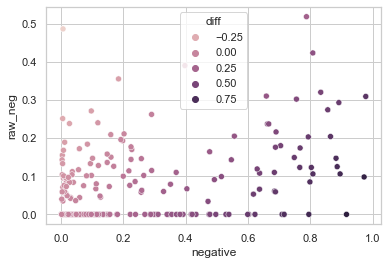

In [ ]:


sns.set(style="whitegrid")
tmp = df[df['matchday_hashtag']=='#BREARS']


tmp['diff'] = df['negative'] - df['raw_neg']
tmp.head()
# create a line plot of the diff column
sns.scatterplot(x='negative', y='raw_neg', hue='diff', data=tmp)



In [ ]:
df.groupby(['team_name', 'GW']).agg({'text':'size',
    'raw_neg':'mean',
    'raw_neu':'mean',
    'raw_pos':'mean',
    'raw_compound':'mean',
    'negative':'mean',
    'neutral':'mean',
    'positive':'mean'}).reset_index().rename(columns={'text':'tweet_count', 'raq_neg':'raw_neg'}).to_csv("grouped_team_sent.csv")

## PLAYERS DATA

In [22]:
players_tweet = pd.read_csv("data/all_players_2021_2022.csv")
players_tweet.head()

,[0-388] all_player_tweets_2021_2022,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,name,GW,text,id,author_id
1,David de Gea,1,[#PL🇬🇧] Les compos de #MUNLEE \n\nMANCHESTER U...,1.42651E+18,1.19023E+18
2,David de Gea,1,Ole should’ve started matic and van de beek in...,1.4265E+18,1.26361E+18
3,David de Gea,1,"🔥SEBELAS PERTAMA🔥\nde Gea; Wan-Bissaka, Lindel...",1.4265E+18,1.36225E+18
4,David de Gea,1,"Only Ole would start James, Fred and McTominay...",1.4265E+18,9.98115E+17


In [23]:
players_tweet.columns = players_tweet.iloc[0]
players_tweet.head()

,name,GW,text,id,author_id
0,name,GW,text,id,author_id
1,David de Gea,1,[#PL🇬🇧] Les compos de #MUNLEE \n\nMANCHESTER U...,1.42651E+18,1.19023E+18
2,David de Gea,1,Ole should’ve started matic and van de beek in...,1.4265E+18,1.26361E+18
3,David de Gea,1,"🔥SEBELAS PERTAMA🔥\nde Gea; Wan-Bissaka, Lindel...",1.4265E+18,1.36225E+18
4,David de Gea,1,"Only Ole would start James, Fred and McTominay...",1.4265E+18,9.98115E+17


In [24]:
players_tweet = players_tweet[players_tweet['name']!='name']
players_tweet['text'] = players_tweet['text'].astype('str')

In [25]:
players_tweet['preprocess'] = players_tweet['text'].apply(preprocess)
players_tweet.head()

,name,GW,text,id,author_id,preprocess
1,David de Gea,1,[#PL🇬🇧] Les compos de #MUNLEE \n\nMANCHESTER U...,1.42651E+18,1.19023E+18,[#PL🇬🇧] Les compos de #MUNLEE \n\nMANCHESTER U...
2,David de Gea,1,Ole should’ve started matic and van de beek in...,1.4265E+18,1.26361E+18,Ole should’ve started matic and van de beek in...
3,David de Gea,1,"🔥SEBELAS PERTAMA🔥\nde Gea; Wan-Bissaka, Lindel...",1.4265E+18,1.36225E+18,"🔥SEBELAS PERTAMA🔥\nde Gea; Wan-Bissaka, Lindel..."
4,David de Gea,1,"Only Ole would start James, Fred and McTominay...",1.4265E+18,9.98115E+17,"Only Ole would start James, Fred and McTominay..."
5,David de Gea,1,Expected to see Von de Beek start ahead of Fre...,1.4265E+18,47167106,Expected to see Von de Beek start ahead of Fre...


## Get player Tweet sentiment using roBERTa

In [ ]:
players_tweet['score'] = players_tweet['preprocess'].apply(encode)

## Get player Tweet sentiment using Vader

In [27]:
sid = SentimentIntensityAnalyzer()
players_tweet = players_tweet.join(pd.DataFrame(players_tweet['text'].apply(lambda x: sid.polarity_scores(x)).values.tolist()))
players_tweet.rename(columns={'pos':'raw_pos','neu':'raw_neu', 'neg':'raw_neg', 'compound':'raw_compound'}, inplace=True)
players_tweet.head()

AttributeError: 'float' object has no attribute 'encode'

## OR just load the file

In [26]:
players_tweet = pd.read_csv('data/player_tweet_sentiment.csv')

## Generating a Density plot between two sentiment analysis models

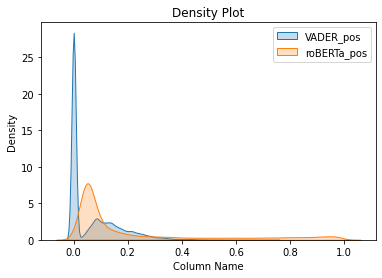

In [28]:

sns.kdeplot(players_tweet["raw_pos"],fill=True, label='VADER_pos')
sns.kdeplot(players_tweet["positive"],fill=True, label="roBERTa_pos")
plt.xlabel('Column Name')
plt.ylabel('Density')
plt.title('Density Plot')
plt.legend()
plt.show()

## Generating label for each tweet

In [29]:
roberta_sent_columns = ['positive', 'negative', 'neutral']
players_tweet['roberta_sentiment'] = players_tweet[roberta_sent_columns].idxmax(axis=1)

vader_sent_columns = ['raw_pos', 'raw_neg', 'raw_neu']
players_tweet['vader_sentiment'] = players_tweet[vader_sent_columns].idxmax(axis=1)
players_tweet

,Unnamed: 0,name,GW,text,id,author_id,preprocess,score,negative,neutral,positive,raw_neg,raw_neu,raw_pos,raw_compound,roberta_sentiment,vader_sentiment
0,1,David de Gea,1.0,[#PL🇬🇧] Les compos de #MUNLEE \n\nMANCHESTER U...,1.426510e+18,1.190230e+18,[#PL🇬🇧] Les compos de #MUNLEE \n\nMANCHESTER U...,[0.05326279 0.9024583 0.04427886],0.053263,0.902458,0.044279,0.0,0.936,0.064,0.3400,neutral,raw_neu
1,2,David de Gea,1.0,Ole should’ve started matic and van de beek in...,1.426500e+18,1.263610e+18,Ole should’ve started matic and van de beek in...,[0.21797596 0.63315696 0.14886707],0.217976,0.633157,0.148867,0.0,1.000,0.000,0.0000,neutral,raw_neu
2,3,David de Gea,1.0,"🔥SEBELAS PERTAMA🔥\nde Gea; Wan-Bissaka, Lindel...",1.426500e+18,1.362250e+18,"🔥SEBELAS PERTAMA🔥\nde Gea; Wan-Bissaka, Lindel...",[0.02449592 0.86005425 0.1154498 ],0.024496,0.860054,0.115450,0.0,1.000,0.000,0.0000,neutral,raw_neu
3,4,David de Gea,1.0,"Only Ole would start James, Fred and McTominay...",1.426500e+18,9.981150e+17,"Only Ole would start James, Fred and McTominay...",[0.14332546 0.7835591 0.0731155 ],0.143325,0.783559,0.073115,0.0,0.919,0.081,0.3182,neutral,raw_neu
4,5,David de Gea,1.0,Expected to see Von de Beek start ahead of Fre...,1.426500e+18,4.716711e+07,Expected to see Von de Beek start ahead of Fre...,[0.01101302 0.403073 0.5859139 ],0.011013,0.403073,0.585914,0.0,0.877,0.123,0.6808,positive,raw_neu
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294289,310058,Moussa Djenepo,37.0,"Southampton XI: McCarthy, Walker-Peters, Steph...",1.526620e+18,3.814262e+07,"Southampton XI: McCarthy, Walker-Peters, Steph...",[0.03915032 0.9088629 0.05198685],0.039150,0.908863,0.051987,NaN,NaN,NaN,NaN,neutral,NaN
294290,310059,Moussa Djenepo,37.0,"📋 #SaintsFC team to face #LFC: McCarthy, Walke...",1.526620e+18,6.264842e+08,"📋 #SaintsFC team to face #LFC: McCarthy, Walke...",[0.04360628 0.9190861 0.03730762],0.043606,0.919086,0.037308,NaN,NaN,NaN,NaN,neutral,NaN
294291,310060,Moussa Djenepo,37.0,"Southampton XI: McCarthy, Lyanco, Salisu, Step...",1.526620e+18,2.356312e+09,"Southampton XI: McCarthy, Lyanco, Salisu, Step...",[0.03997984 0.91489977 0.04512047],0.039980,0.914900,0.045120,NaN,NaN,NaN,NaN,neutral,NaN
294292,310062,Moussa Djenepo,38.0,@SouthamptonFC Last Game for Djenepo and Walco...,1.528380e+18,1.255928e+08,@user Last Game for Djenepo and Walcott ….Will...,[0.00150203 0.06800786 0.9304901 ],0.001502,0.068008,0.930490,NaN,NaN,NaN,NaN,positive,NaN


In [30]:
mapping ={'raw_neu':0, 'raw_pos': 1, 'raw_neg':-1}
players_tweet['vader_sentiment'] = players_tweet['vader_sentiment'].map(mapping)
players_tweet.head()

,Unnamed: 0,name,GW,text,id,author_id,preprocess,score,negative,neutral,positive,raw_neg,raw_neu,raw_pos,raw_compound,roberta_sentiment,vader_sentiment
0,1,David de Gea,1.0,[#PL🇬🇧] Les compos de #MUNLEE \n\nMANCHESTER U...,1.426510e+18,1.190230e+18,[#PL🇬🇧] Les compos de #MUNLEE \n\nMANCHESTER U...,[0.05326279 0.9024583 0.04427886],0.053263,0.902458,0.044279,0.0,0.936,0.064,0.3400,neutral,0.0
1,2,David de Gea,1.0,Ole should’ve started matic and van de beek in...,1.426500e+18,1.263610e+18,Ole should’ve started matic and van de beek in...,[0.21797596 0.63315696 0.14886707],0.217976,0.633157,0.148867,0.0,1.000,0.000,0.0000,neutral,0.0
2,3,David de Gea,1.0,"🔥SEBELAS PERTAMA🔥\nde Gea; Wan-Bissaka, Lindel...",1.426500e+18,1.362250e+18,"🔥SEBELAS PERTAMA🔥\nde Gea; Wan-Bissaka, Lindel...",[0.02449592 0.86005425 0.1154498 ],0.024496,0.860054,0.115450,0.0,1.000,0.000,0.0000,neutral,0.0
3,4,David de Gea,1.0,"Only Ole would start James, Fred and McTominay...",1.426500e+18,9.981150e+17,"Only Ole would start James, Fred and McTominay...",[0.14332546 0.7835591 0.0731155 ],0.143325,0.783559,0.073115,0.0,0.919,0.081,0.3182,neutral,0.0
4,5,David de Gea,1.0,Expected to see Von de Beek start ahead of Fre...,1.426500e+18,4.716711e+07,Expected to see Von de Beek start ahead of Fre...,[0.01101302 0.403073 0.5859139 ],0.011013,0.403073,0.585914,0.0,0.877,0.123,0.6808,positive,0.0


neutral     216066
positive     51788
negative     26440
Name: roberta_sentiment, dtype: int64


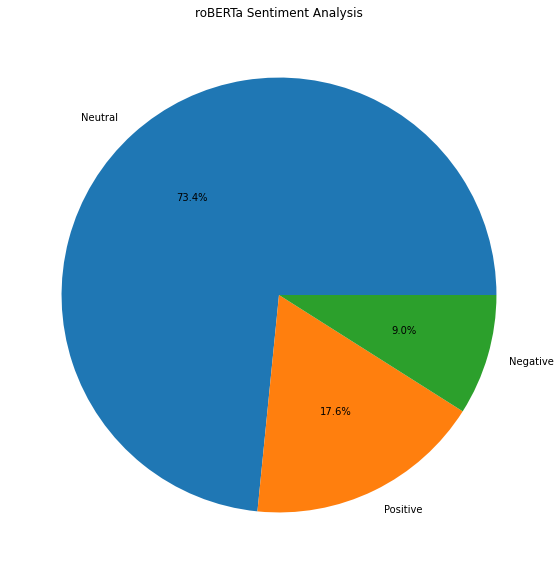

In [31]:
counts = players_tweet['roberta_sentiment'].value_counts()
print(counts)

# Create a pie chart
labels = ['Neutral', 'Positive', 'Negative']
plt.figure(figsize=(10, 10))
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.title('roBERTa Sentiment Analysis')
plt.show()

 0.0    279170
 1.0       404
-1.0       222
Name: vader_sentiment, dtype: int64


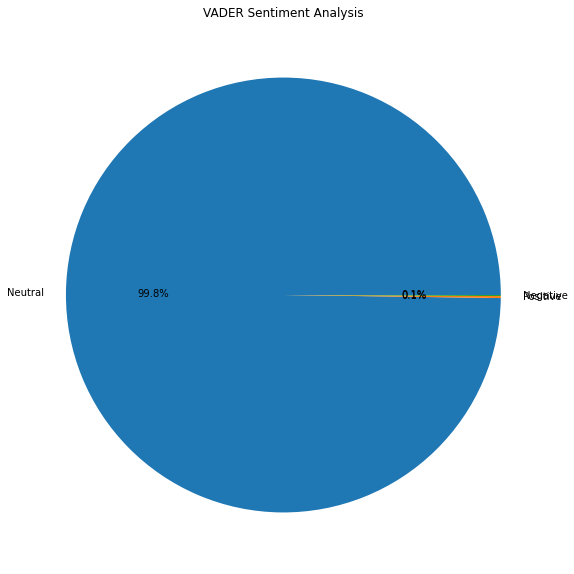

In [32]:
counts = players_tweet['vader_sentiment'].value_counts()
print(counts)

# Create a pie chart
labels = ['Neutral', 'Positive', 'Negative']
plt.figure(figsize=(10, 10))
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.title('VADER Sentiment Analysis')
plt.show()

In [33]:
# players_tweet.to_csv("player_tweet_sentiment.csv")
players_tweet.head()

,Unnamed: 0,name,GW,text,id,author_id,preprocess,score,negative,neutral,positive,raw_neg,raw_neu,raw_pos,raw_compound,roberta_sentiment,vader_sentiment
0,1,David de Gea,1.0,[#PL🇬🇧] Les compos de #MUNLEE \n\nMANCHESTER U...,1.426510e+18,1.190230e+18,[#PL🇬🇧] Les compos de #MUNLEE \n\nMANCHESTER U...,[0.05326279 0.9024583 0.04427886],0.053263,0.902458,0.044279,0.0,0.936,0.064,0.3400,neutral,0.0
1,2,David de Gea,1.0,Ole should’ve started matic and van de beek in...,1.426500e+18,1.263610e+18,Ole should’ve started matic and van de beek in...,[0.21797596 0.63315696 0.14886707],0.217976,0.633157,0.148867,0.0,1.000,0.000,0.0000,neutral,0.0
2,3,David de Gea,1.0,"🔥SEBELAS PERTAMA🔥\nde Gea; Wan-Bissaka, Lindel...",1.426500e+18,1.362250e+18,"🔥SEBELAS PERTAMA🔥\nde Gea; Wan-Bissaka, Lindel...",[0.02449592 0.86005425 0.1154498 ],0.024496,0.860054,0.115450,0.0,1.000,0.000,0.0000,neutral,0.0
3,4,David de Gea,1.0,"Only Ole would start James, Fred and McTominay...",1.426500e+18,9.981150e+17,"Only Ole would start James, Fred and McTominay...",[0.14332546 0.7835591 0.0731155 ],0.143325,0.783559,0.073115,0.0,0.919,0.081,0.3182,neutral,0.0
4,5,David de Gea,1.0,Expected to see Von de Beek start ahead of Fre...,1.426500e+18,4.716711e+07,Expected to see Von de Beek start ahead of Fre...,[0.01101302 0.403073 0.5859139 ],0.011013,0.403073,0.585914,0.0,0.877,0.123,0.6808,positive,0.0


In [34]:
mapping ={'neutral':0, 'positive': 1, 'negative':-1}
players_tweet['roberta_sentiment'] = players_tweet['roberta_sentiment'].map(mapping)
players_tweet.head()

,Unnamed: 0,name,GW,text,id,author_id,preprocess,score,negative,neutral,positive,raw_neg,raw_neu,raw_pos,raw_compound,roberta_sentiment,vader_sentiment
0,1,David de Gea,1.0,[#PL🇬🇧] Les compos de #MUNLEE \n\nMANCHESTER U...,1.426510e+18,1.190230e+18,[#PL🇬🇧] Les compos de #MUNLEE \n\nMANCHESTER U...,[0.05326279 0.9024583 0.04427886],0.053263,0.902458,0.044279,0.0,0.936,0.064,0.3400,0,0.0
1,2,David de Gea,1.0,Ole should’ve started matic and van de beek in...,1.426500e+18,1.263610e+18,Ole should’ve started matic and van de beek in...,[0.21797596 0.63315696 0.14886707],0.217976,0.633157,0.148867,0.0,1.000,0.000,0.0000,0,0.0
2,3,David de Gea,1.0,"🔥SEBELAS PERTAMA🔥\nde Gea; Wan-Bissaka, Lindel...",1.426500e+18,1.362250e+18,"🔥SEBELAS PERTAMA🔥\nde Gea; Wan-Bissaka, Lindel...",[0.02449592 0.86005425 0.1154498 ],0.024496,0.860054,0.115450,0.0,1.000,0.000,0.0000,0,0.0
3,4,David de Gea,1.0,"Only Ole would start James, Fred and McTominay...",1.426500e+18,9.981150e+17,"Only Ole would start James, Fred and McTominay...",[0.14332546 0.7835591 0.0731155 ],0.143325,0.783559,0.073115,0.0,0.919,0.081,0.3182,0,0.0
4,5,David de Gea,1.0,Expected to see Von de Beek start ahead of Fre...,1.426500e+18,4.716711e+07,Expected to see Von de Beek start ahead of Fre...,[0.01101302 0.403073 0.5859139 ],0.011013,0.403073,0.585914,0.0,0.877,0.123,0.6808,1,0.0


## Grouping the players based on name and GW

In [35]:
grouped_players_tweet = players_tweet.groupby(['name', 'GW']).agg({'text':'size',
    'raw_neg':'mean',
    'raw_neu':'mean',
    'raw_pos':'mean',
    'raw_compound':'mean',
    'negative':'mean',
    'neutral':'mean',
    'positive':'mean'}).reset_index().rename(columns={'text':'tweet_count', 'raq_neg':'raw_neg'})

roberta_sent_columns = ['positive', 'negative', 'neutral']
grouped_players_tweet['roberta_sentiment'] = grouped_players_tweet[roberta_sent_columns].idxmax(axis=1)

vader_sent_columns = ['raw_pos', 'raw_neg', 'raw_neu']
grouped_players_tweet['vader_sentiment'] = grouped_players_tweet[vader_sent_columns].idxmax(axis=1)
grouped_players_tweet
                                             

,name,GW,tweet_count,raw_neg,raw_neu,raw_pos,raw_compound,negative,neutral,positive,roberta_sentiment,vader_sentiment
0,S.L. Sterling @PowerofRomance https://t.co/CN...,1.471970e+18,1,0.0000,0.893000,0.107000,0.541100,0.213770,0.593079,0.193150,neutral,raw_neu
1,by @author_k_ryan https://t.co/l635Pl2IGq htt...,1.501660e+18,2,0.0000,0.902500,0.097500,0.390500,0.213770,0.593079,0.193150,neutral,raw_neu
2,by @author_rj #VeteransofValhalla https://t.c...,1.469660e+18,1,0.0970,0.903000,0.000000,-0.258400,0.213770,0.593079,0.193150,neutral,raw_neu
3,#ARSLIV https://t.co/AOMIlcSFqH,1.503660e+18,4,0.0000,0.963750,0.036250,0.280175,0.131323,0.748702,0.119974,neutral,raw_neu
4,#Amazon #WhatToRead #eBook #kindleunlimited #f...,1.433440e+18,1,0.0000,1.000000,0.000000,0.000000,0.239005,0.603027,0.157967,neutral,raw_neu
...,...,...,...,...,...,...,...,...,...,...,...,...
12439,Çaglar Söyüncü,2.600000e+01,7,0.0000,0.920286,0.079714,0.275757,0.481901,0.477320,0.040779,negative,raw_neu
12440,Çaglar Söyüncü,2.700000e+01,1,0.0000,0.865000,0.135000,0.680800,0.399782,0.557591,0.042627,neutral,raw_neu
12441,Çaglar Söyüncü,3.000000e+01,5,0.0134,0.864800,0.121600,0.468860,0.287957,0.646968,0.065074,neutral,raw_neu
12442,Çaglar Söyüncü,3.300000e+01,2,0.1095,0.890500,0.000000,-0.325850,0.040071,0.748494,0.211434,neutral,raw_neu


In [36]:
mapping ={'raw_neu':0, 'raw_pos': 1, 'raw_nge':-1}
grouped_players_tweet['vader_sentiment'] = grouped_players_tweet['vader_sentiment'].map(mapping)
grouped_players_tweet.head()


,name,GW,tweet_count,raw_neg,raw_neu,raw_pos,raw_compound,negative,neutral,positive,roberta_sentiment,vader_sentiment
0,S.L. Sterling @PowerofRomance https://t.co/CN...,1.471970e+18,1,0.000,0.89300,0.10700,0.541100,0.213770,0.593079,0.193150,neutral,0.0
1,by @author_k_ryan https://t.co/l635Pl2IGq htt...,1.501660e+18,2,0.000,0.90250,0.09750,0.390500,0.213770,0.593079,0.193150,neutral,0.0
2,by @author_rj #VeteransofValhalla https://t.c...,1.469660e+18,1,0.097,0.90300,0.00000,-0.258400,0.213770,0.593079,0.193150,neutral,0.0
3,#ARSLIV https://t.co/AOMIlcSFqH,1.503660e+18,4,0.000,0.96375,0.03625,0.280175,0.131323,0.748702,0.119974,neutral,0.0
4,#Amazon #WhatToRead #eBook #kindleunlimited #f...,1.433440e+18,1,0.000,1.00000,0.00000,0.000000,0.239005,0.603027,0.157967,neutral,0.0


In [37]:
grouped_players_tweet['roberta_sentiment'].value_counts()

neutral     11888
positive      405
negative      151
Name: roberta_sentiment, dtype: int64

## Building Statistical Model

In [39]:
top_player = []
players_df = pd.read_csv("data/cleaned_merged_seasons.csv", low_memory=False)
players_df = players_df.loc[(players_df["season_x"] == '2021-22')]
players_df 

,Unnamed: 0,season_x,name,position,team_x,assists,bonus,bps,clean_sheets,creativity,...,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW
76041,76041,2021-22,Eric Bailly,DEF,Man Utd,0,0,0,0,0.0,...,5.0,0.0,0,0,0,0,50,True,0,1.0
76042,76042,2021-22,Keinan Davis,FWD,Aston Villa,0,0,0,0,0.0,...,3.0,0.0,0,0,0,0,45,False,0,1.0
76043,76043,2021-22,Ayotomiwa Dele-Bashiru,MID,Watford,0,0,0,0,0.0,...,3.0,0.0,0,0,0,0,45,True,0,1.0
76044,76044,2021-22,James Ward-Prowse,MID,Southampton,0,0,20,0,30.5,...,3.0,0.0,2,0,0,0,65,False,0,1.0
76045,76045,2021-22,Bruno Miguel Borges Fernandes,MID,Man Utd,0,3,61,0,35.9,...,5.0,59.0,20,0,0,0,120,True,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101483,101483,2021-22,Wilfred Ndidi,MID,Leicester,0,0,0,0,0.0,...,4.0,0.0,0,-202,22,224,48,True,0,38.0
101484,101484,2021-22,Matt Ritchie,DEF,Newcastle,0,0,3,0,0.0,...,1.0,0.0,1,143,396,253,49,False,0,38.0
101485,101485,2021-22,Nathan Redmond,MID,Southampton,0,0,5,0,0.0,...,4.0,0.0,2,455,683,228,59,False,0,38.0
101486,101486,2021-22,Mathew Ryan,GK,Brighton,0,0,0,0,0.0,...,3.0,0.0,0,-2,0,2,45,True,0,38.0


In [42]:
sentiment_df = grouped_players_tweet
sentiment_df

,name,GW,tweet_count,raw_neg,raw_neu,raw_pos,raw_compound,negative,neutral,positive,roberta_sentiment,vader_sentiment
0,S.L. Sterling @PowerofRomance https://t.co/CN...,1.471970e+18,1,0.0000,0.893000,0.107000,0.541100,0.213770,0.593079,0.193150,neutral,0.0
1,by @author_k_ryan https://t.co/l635Pl2IGq htt...,1.501660e+18,2,0.0000,0.902500,0.097500,0.390500,0.213770,0.593079,0.193150,neutral,0.0
2,by @author_rj #VeteransofValhalla https://t.c...,1.469660e+18,1,0.0970,0.903000,0.000000,-0.258400,0.213770,0.593079,0.193150,neutral,0.0
3,#ARSLIV https://t.co/AOMIlcSFqH,1.503660e+18,4,0.0000,0.963750,0.036250,0.280175,0.131323,0.748702,0.119974,neutral,0.0
4,#Amazon #WhatToRead #eBook #kindleunlimited #f...,1.433440e+18,1,0.0000,1.000000,0.000000,0.000000,0.239005,0.603027,0.157967,neutral,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
12439,Çaglar Söyüncü,2.600000e+01,7,0.0000,0.920286,0.079714,0.275757,0.481901,0.477320,0.040779,negative,0.0
12440,Çaglar Söyüncü,2.700000e+01,1,0.0000,0.865000,0.135000,0.680800,0.399782,0.557591,0.042627,neutral,0.0
12441,Çaglar Söyüncü,3.000000e+01,5,0.0134,0.864800,0.121600,0.468860,0.287957,0.646968,0.065074,neutral,0.0
12442,Çaglar Söyüncü,3.300000e+01,2,0.1095,0.890500,0.000000,-0.325850,0.040071,0.748494,0.211434,neutral,0.0


In [43]:
#sentiment_df['roberta_sentiment'] = sentiment_df['roberta_sentiment'].replace("neutral", 0)
#sentiment_df['roberta_sentiment'] = sentiment_df['roberta_sentiment'].replace("positive", 1)
#sentiment_df['roberta_sentiment'] = sentiment_df['roberta_sentiment'].replace("negative", -1)
#sentiment_df['vader_sentiment'] = sentiment_df['vader_sentiment'].replace("neutral", 0)
#sentiment_df['vader_sentiment'] = sentiment_df['vader_sentiment'].replace("positive", 1)
#sentiment_df['vader_sentiment'] = sentiment_df['vader_sentiment'].replace("negative", -1)
#sentiment_df['vader_sentiment'] = sentiment_df['vader_sentiment'].replace(np.NaN, 0)
sentiment_df = sentiment_df.drop(['tweet_count', 'raw_neg', 'raw_neu', 'raw_pos', 'raw_compound', 'roberta_sentiment' , 'vader_sentiment'], axis = 1)
sentiment_df['GW'] = sentiment_df['GW'].replace(np.NaN, 0)
sentiment_df['GW'] = sentiment_df['GW'].astype(int)

sentiment_df

,name,GW,negative,neutral,positive
0,S.L. Sterling @PowerofRomance https://t.co/CN...,1471970000000000000,0.213770,0.593079,0.193150
1,by @author_k_ryan https://t.co/l635Pl2IGq htt...,1501660000000000000,0.213770,0.593079,0.193150
2,by @author_rj #VeteransofValhalla https://t.c...,1469660000000000000,0.213770,0.593079,0.193150
3,#ARSLIV https://t.co/AOMIlcSFqH,1503660000000000000,0.131323,0.748702,0.119974
4,#Amazon #WhatToRead #eBook #kindleunlimited #f...,1433440000000000000,0.239005,0.603027,0.157967
...,...,...,...,...,...
12439,Çaglar Söyüncü,26,0.481901,0.477320,0.040779
12440,Çaglar Söyüncü,27,0.399782,0.557591,0.042627
12441,Çaglar Söyüncü,30,0.287957,0.646968,0.065074
12442,Çaglar Söyüncü,33,0.040071,0.748494,0.211434


In [44]:
#sentiment_df = pd.read_csv('filtered_data.csv', low_memory=False)
sentiment_df['join_field_sentiment'] = sentiment_df['name']+ "_"+ "2021-22" +"_"+ sentiment_df['GW'].astype(str)
sentiment_df = sentiment_df.iloc[1: , :]
sentiment_df

,name,GW,negative,neutral,positive,join_field_sentiment
1,by @author_k_ryan https://t.co/l635Pl2IGq htt...,1501660000000000000,0.213770,0.593079,0.193150,by @author_k_ryan https://t.co/l635Pl2IGq htt...
2,by @author_rj #VeteransofValhalla https://t.c...,1469660000000000000,0.213770,0.593079,0.193150,by @author_rj #VeteransofValhalla https://t.c...
3,#ARSLIV https://t.co/AOMIlcSFqH,1503660000000000000,0.131323,0.748702,0.119974,#ARSLIV https://t.co/AOMIlcSFqH_2021-22_150366...
4,#Amazon #WhatToRead #eBook #kindleunlimited #f...,1433440000000000000,0.239005,0.603027,0.157967,#Amazon #WhatToRead #eBook #kindleunlimited #f...
5,Aaron Cresswell,1,0.038423,0.854043,0.107534,Aaron Cresswell_2021-22_1
...,...,...,...,...,...,...
12439,Çaglar Söyüncü,26,0.481901,0.477320,0.040779,Çaglar Söyüncü_2021-22_26
12440,Çaglar Söyüncü,27,0.399782,0.557591,0.042627,Çaglar Söyüncü_2021-22_27
12441,Çaglar Söyüncü,30,0.287957,0.646968,0.065074,Çaglar Söyüncü_2021-22_30
12442,Çaglar Söyüncü,33,0.040071,0.748494,0.211434,Çaglar Söyüncü_2021-22_33


In [45]:
players_list_df = players_df[['name' , 'total_points', 'GW', 'season_x']]
players_df['join_field'] = players_df['name'] +"_"+ players_df['season_x'] +"_"+ players_df['GW'].astype(str)


#top_player = players_df.sort_values('selected', ascending=False).drop_duplicates(['name']).head(75)
#players_df = players_df[players_df['name'].isin(top_player['name'])]

players_df

,Unnamed: 0,season_x,name,position,team_x,assists,bonus,bps,clean_sheets,creativity,...,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW,join_field
76041,76041,2021-22,Eric Bailly,DEF,Man Utd,0,0,0,0,0.0,...,0.0,0,0,0,0,50,True,0,1.0,Eric Bailly_2021-22_1.0
76042,76042,2021-22,Keinan Davis,FWD,Aston Villa,0,0,0,0,0.0,...,0.0,0,0,0,0,45,False,0,1.0,Keinan Davis_2021-22_1.0
76043,76043,2021-22,Ayotomiwa Dele-Bashiru,MID,Watford,0,0,0,0,0.0,...,0.0,0,0,0,0,45,True,0,1.0,Ayotomiwa Dele-Bashiru_2021-22_1.0
76044,76044,2021-22,James Ward-Prowse,MID,Southampton,0,0,20,0,30.5,...,0.0,2,0,0,0,65,False,0,1.0,James Ward-Prowse_2021-22_1.0
76045,76045,2021-22,Bruno Miguel Borges Fernandes,MID,Man Utd,0,3,61,0,35.9,...,59.0,20,0,0,0,120,True,0,1.0,Bruno Miguel Borges Fernandes_2021-22_1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101483,101483,2021-22,Wilfred Ndidi,MID,Leicester,0,0,0,0,0.0,...,0.0,0,-202,22,224,48,True,0,38.0,Wilfred Ndidi_2021-22_38.0
101484,101484,2021-22,Matt Ritchie,DEF,Newcastle,0,0,3,0,0.0,...,0.0,1,143,396,253,49,False,0,38.0,Matt Ritchie_2021-22_38.0
101485,101485,2021-22,Nathan Redmond,MID,Southampton,0,0,5,0,0.0,...,0.0,2,455,683,228,59,False,0,38.0,Nathan Redmond_2021-22_38.0
101486,101486,2021-22,Mathew Ryan,GK,Brighton,0,0,0,0,0.0,...,0.0,0,-2,0,2,45,True,0,38.0,Mathew Ryan_2021-22_38.0


In [46]:
players_df = pd.merge(players_df, sentiment_df,  how='left', left_on=['join_field'], right_on = ['join_field_sentiment'])
players_df

,Unnamed: 0,season_x,name_x,position,team_x,assists,bonus,bps,clean_sheets,creativity,...,was_home,yellow_cards,GW_x,join_field,name_y,GW_y,negative,neutral,positive,join_field_sentiment
0,76041,2021-22,Eric Bailly,DEF,Man Utd,0,0,0,0,0.0,...,True,0,1.0,Eric Bailly_2021-22_1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,76042,2021-22,Keinan Davis,FWD,Aston Villa,0,0,0,0,0.0,...,False,0,1.0,Keinan Davis_2021-22_1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,76043,2021-22,Ayotomiwa Dele-Bashiru,MID,Watford,0,0,0,0,0.0,...,True,0,1.0,Ayotomiwa Dele-Bashiru_2021-22_1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,76044,2021-22,James Ward-Prowse,MID,Southampton,0,0,20,0,30.5,...,False,0,1.0,James Ward-Prowse_2021-22_1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,76045,2021-22,Bruno Miguel Borges Fernandes,MID,Man Utd,0,3,61,0,35.9,...,True,0,1.0,Bruno Miguel Borges Fernandes_2021-22_1.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25442,101483,2021-22,Wilfred Ndidi,MID,Leicester,0,0,0,0,0.0,...,True,0,38.0,Wilfred Ndidi_2021-22_38.0,NaN,NaN,NaN,NaN,NaN,NaN
25443,101484,2021-22,Matt Ritchie,DEF,Newcastle,0,0,3,0,0.0,...,False,0,38.0,Matt Ritchie_2021-22_38.0,NaN,NaN,NaN,NaN,NaN,NaN
25444,101485,2021-22,Nathan Redmond,MID,Southampton,0,0,5,0,0.0,...,False,0,38.0,Nathan Redmond_2021-22_38.0,NaN,NaN,NaN,NaN,NaN,NaN
25445,101486,2021-22,Mathew Ryan,GK,Brighton,0,0,0,0,0.0,...,True,0,38.0,Mathew Ryan_2021-22_38.0,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
players_list_df
players_list_df['required_gw'] = players_list_df['GW'] - 1
players_list_df

/var/folders/jc/p7myh4c15592hx_1frgfvyl80000gn/T/ipykernel_13949/4251877298.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players_list_df['required_gw'] = players_list_df['GW'] - 1


,name,total_points,GW,season_x,required_gw
76041,Eric Bailly,0,1.0,2021-22,0.0
76042,Keinan Davis,0,1.0,2021-22,0.0
76043,Ayotomiwa Dele-Bashiru,0,1.0,2021-22,0.0
76044,James Ward-Prowse,2,1.0,2021-22,0.0
76045,Bruno Miguel Borges Fernandes,20,1.0,2021-22,0.0
...,...,...,...,...,...
101483,Wilfred Ndidi,0,38.0,2021-22,37.0
101484,Matt Ritchie,1,38.0,2021-22,37.0
101485,Nathan Redmond,2,38.0,2021-22,37.0
101486,Mathew Ryan,0,38.0,2021-22,37.0


In [48]:
players_list_df['join_field'] = players_list_df['name'] +"_"+ players_list_df['season_x'] +"_"+ players_list_df['required_gw'].astype(str)
players_list_df
#players_list_df.to_csv("player_list.csv")

/var/folders/jc/p7myh4c15592hx_1frgfvyl80000gn/T/ipykernel_13949/981548937.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players_list_df['join_field'] = players_list_df['name'] +"_"+ players_list_df['season_x'] +"_"+ players_list_df['required_gw'].astype(str)


,name,total_points,GW,season_x,required_gw,join_field
76041,Eric Bailly,0,1.0,2021-22,0.0,Eric Bailly_2021-22_0.0
76042,Keinan Davis,0,1.0,2021-22,0.0,Keinan Davis_2021-22_0.0
76043,Ayotomiwa Dele-Bashiru,0,1.0,2021-22,0.0,Ayotomiwa Dele-Bashiru_2021-22_0.0
76044,James Ward-Prowse,2,1.0,2021-22,0.0,James Ward-Prowse_2021-22_0.0
76045,Bruno Miguel Borges Fernandes,20,1.0,2021-22,0.0,Bruno Miguel Borges Fernandes_2021-22_0.0
...,...,...,...,...,...,...
101483,Wilfred Ndidi,0,38.0,2021-22,37.0,Wilfred Ndidi_2021-22_37.0
101484,Matt Ritchie,1,38.0,2021-22,37.0,Matt Ritchie_2021-22_37.0
101485,Nathan Redmond,2,38.0,2021-22,37.0,Nathan Redmond_2021-22_37.0
101486,Mathew Ryan,0,38.0,2021-22,37.0,Mathew Ryan_2021-22_37.0


In [49]:
players_df = pd.merge(players_df, players_list_df,  how='left', left_on=['join_field'], right_on = ['join_field'])
players_df = players_df.rename(columns = {'total_points_y': 'next_gameweek_point'})
players_df = players_df.drop(['join_field', 'name_y', 'GW_y', 'season_x_y', 'required_gw'], axis = 1)

players_df.to_csv('df_with_sentiment.csv')

In [50]:
players_df

,Unnamed: 0,season_x_x,name_x,position,team_x,assists,bonus,bps,clean_sheets,creativity,...,was_home,yellow_cards,GW_x,negative,neutral,positive,join_field_sentiment,name,next_gameweek_point,GW
0,76041,2021-22,Eric Bailly,DEF,Man Utd,0,0,0,0,0.0,...,True,0,1.0,NaN,NaN,NaN,NaN,Eric Bailly,0.0,2.0
1,76042,2021-22,Keinan Davis,FWD,Aston Villa,0,0,0,0,0.0,...,False,0,1.0,NaN,NaN,NaN,NaN,Keinan Davis,0.0,2.0
2,76043,2021-22,Ayotomiwa Dele-Bashiru,MID,Watford,0,0,0,0,0.0,...,True,0,1.0,NaN,NaN,NaN,NaN,Ayotomiwa Dele-Bashiru,0.0,2.0
3,76044,2021-22,James Ward-Prowse,MID,Southampton,0,0,20,0,30.5,...,False,0,1.0,NaN,NaN,NaN,NaN,James Ward-Prowse,2.0,2.0
4,76045,2021-22,Bruno Miguel Borges Fernandes,MID,Man Utd,0,3,61,0,35.9,...,True,0,1.0,NaN,NaN,NaN,NaN,Bruno Miguel Borges Fernandes,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27748,101483,2021-22,Wilfred Ndidi,MID,Leicester,0,0,0,0,0.0,...,True,0,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27749,101484,2021-22,Matt Ritchie,DEF,Newcastle,0,0,3,0,0.0,...,False,0,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27750,101485,2021-22,Nathan Redmond,MID,Southampton,0,0,5,0,0.0,...,False,0,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27751,101486,2021-22,Mathew Ryan,GK,Brighton,0,0,0,0,0.0,...,True,0,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
players_df['select'] = players_df['next_gameweek_point'].apply(lambda x: 1 if x >= 4 else 0)
players_df

,Unnamed: 0,season_x_x,name_x,position,team_x,assists,bonus,bps,clean_sheets,creativity,...,yellow_cards,GW_x,negative,neutral,positive,join_field_sentiment,name,next_gameweek_point,GW,select
0,76041,2021-22,Eric Bailly,DEF,Man Utd,0,0,0,0,0.0,...,0,1.0,NaN,NaN,NaN,NaN,Eric Bailly,0.0,2.0,0
1,76042,2021-22,Keinan Davis,FWD,Aston Villa,0,0,0,0,0.0,...,0,1.0,NaN,NaN,NaN,NaN,Keinan Davis,0.0,2.0,0
2,76043,2021-22,Ayotomiwa Dele-Bashiru,MID,Watford,0,0,0,0,0.0,...,0,1.0,NaN,NaN,NaN,NaN,Ayotomiwa Dele-Bashiru,0.0,2.0,0
3,76044,2021-22,James Ward-Prowse,MID,Southampton,0,0,20,0,30.5,...,0,1.0,NaN,NaN,NaN,NaN,James Ward-Prowse,2.0,2.0,0
4,76045,2021-22,Bruno Miguel Borges Fernandes,MID,Man Utd,0,3,61,0,35.9,...,0,1.0,NaN,NaN,NaN,NaN,Bruno Miguel Borges Fernandes,1.0,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27748,101483,2021-22,Wilfred Ndidi,MID,Leicester,0,0,0,0,0.0,...,0,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
27749,101484,2021-22,Matt Ritchie,DEF,Newcastle,0,0,3,0,0.0,...,0,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
27750,101485,2021-22,Nathan Redmond,MID,Southampton,0,0,5,0,0.0,...,0,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
27751,101486,2021-22,Mathew Ryan,GK,Brighton,0,0,0,0,0.0,...,0,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


## fillna

In [53]:
for column in players_df.columns:
    players_df[column] = players_df[column].fillna(0) #using '0' to fill na.
    
players_df

,Unnamed: 0,season_x_x,name_x,position,team_x,assists,bonus,bps,clean_sheets,creativity,...,yellow_cards,GW_x,negative,neutral,positive,join_field_sentiment,name,next_gameweek_point,GW,select
0,76041,2021-22,Eric Bailly,DEF,Man Utd,0,0,0,0,0.0,...,0,1.0,0.0,0.0,0.0,0,Eric Bailly,0.0,2.0,0
1,76042,2021-22,Keinan Davis,FWD,Aston Villa,0,0,0,0,0.0,...,0,1.0,0.0,0.0,0.0,0,Keinan Davis,0.0,2.0,0
2,76043,2021-22,Ayotomiwa Dele-Bashiru,MID,Watford,0,0,0,0,0.0,...,0,1.0,0.0,0.0,0.0,0,Ayotomiwa Dele-Bashiru,0.0,2.0,0
3,76044,2021-22,James Ward-Prowse,MID,Southampton,0,0,20,0,30.5,...,0,1.0,0.0,0.0,0.0,0,James Ward-Prowse,2.0,2.0,0
4,76045,2021-22,Bruno Miguel Borges Fernandes,MID,Man Utd,0,3,61,0,35.9,...,0,1.0,0.0,0.0,0.0,0,Bruno Miguel Borges Fernandes,1.0,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27748,101483,2021-22,Wilfred Ndidi,MID,Leicester,0,0,0,0,0.0,...,0,38.0,0.0,0.0,0.0,0,0,0.0,0.0,0
27749,101484,2021-22,Matt Ritchie,DEF,Newcastle,0,0,3,0,0.0,...,0,38.0,0.0,0.0,0.0,0,0,0.0,0.0,0
27750,101485,2021-22,Nathan Redmond,MID,Southampton,0,0,5,0,0.0,...,0,38.0,0.0,0.0,0.0,0,0,0.0,0.0,0
27751,101486,2021-22,Mathew Ryan,GK,Brighton,0,0,0,0,0.0,...,0,38.0,0.0,0.0,0.0,0,0,0.0,0.0,0


## finding and removing outliers

In [54]:

threshold = 0.7
players_df = players_df[players_df.columns[players_df.isnull().mean() < threshold]] 
players_df

,Unnamed: 0,season_x_x,name_x,position,team_x,assists,bonus,bps,clean_sheets,creativity,...,yellow_cards,GW_x,negative,neutral,positive,join_field_sentiment,name,next_gameweek_point,GW,select
0,76041,2021-22,Eric Bailly,DEF,Man Utd,0,0,0,0,0.0,...,0,1.0,0.0,0.0,0.0,0,Eric Bailly,0.0,2.0,0
1,76042,2021-22,Keinan Davis,FWD,Aston Villa,0,0,0,0,0.0,...,0,1.0,0.0,0.0,0.0,0,Keinan Davis,0.0,2.0,0
2,76043,2021-22,Ayotomiwa Dele-Bashiru,MID,Watford,0,0,0,0,0.0,...,0,1.0,0.0,0.0,0.0,0,Ayotomiwa Dele-Bashiru,0.0,2.0,0
3,76044,2021-22,James Ward-Prowse,MID,Southampton,0,0,20,0,30.5,...,0,1.0,0.0,0.0,0.0,0,James Ward-Prowse,2.0,2.0,0
4,76045,2021-22,Bruno Miguel Borges Fernandes,MID,Man Utd,0,3,61,0,35.9,...,0,1.0,0.0,0.0,0.0,0,Bruno Miguel Borges Fernandes,1.0,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27748,101483,2021-22,Wilfred Ndidi,MID,Leicester,0,0,0,0,0.0,...,0,38.0,0.0,0.0,0.0,0,0,0.0,0.0,0
27749,101484,2021-22,Matt Ritchie,DEF,Newcastle,0,0,3,0,0.0,...,0,38.0,0.0,0.0,0.0,0,0,0.0,0.0,0
27750,101485,2021-22,Nathan Redmond,MID,Southampton,0,0,5,0,0.0,...,0,38.0,0.0,0.0,0.0,0,0,0.0,0.0,0
27751,101486,2021-22,Mathew Ryan,GK,Brighton,0,0,0,0,0.0,...,0,38.0,0.0,0.0,0.0,0,0,0.0,0.0,0


In [55]:
players_df["was_home"] = players_df["was_home"].astype(int)
players_df

,Unnamed: 0,season_x_x,name_x,position,team_x,assists,bonus,bps,clean_sheets,creativity,...,yellow_cards,GW_x,negative,neutral,positive,join_field_sentiment,name,next_gameweek_point,GW,select
0,76041,2021-22,Eric Bailly,DEF,Man Utd,0,0,0,0,0.0,...,0,1.0,0.0,0.0,0.0,0,Eric Bailly,0.0,2.0,0
1,76042,2021-22,Keinan Davis,FWD,Aston Villa,0,0,0,0,0.0,...,0,1.0,0.0,0.0,0.0,0,Keinan Davis,0.0,2.0,0
2,76043,2021-22,Ayotomiwa Dele-Bashiru,MID,Watford,0,0,0,0,0.0,...,0,1.0,0.0,0.0,0.0,0,Ayotomiwa Dele-Bashiru,0.0,2.0,0
3,76044,2021-22,James Ward-Prowse,MID,Southampton,0,0,20,0,30.5,...,0,1.0,0.0,0.0,0.0,0,James Ward-Prowse,2.0,2.0,0
4,76045,2021-22,Bruno Miguel Borges Fernandes,MID,Man Utd,0,3,61,0,35.9,...,0,1.0,0.0,0.0,0.0,0,Bruno Miguel Borges Fernandes,1.0,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27748,101483,2021-22,Wilfred Ndidi,MID,Leicester,0,0,0,0,0.0,...,0,38.0,0.0,0.0,0.0,0,0,0.0,0.0,0
27749,101484,2021-22,Matt Ritchie,DEF,Newcastle,0,0,3,0,0.0,...,0,38.0,0.0,0.0,0.0,0,0,0.0,0.0,0
27750,101485,2021-22,Nathan Redmond,MID,Southampton,0,0,5,0,0.0,...,0,38.0,0.0,0.0,0.0,0,0,0.0,0.0,0
27751,101486,2021-22,Mathew Ryan,GK,Brighton,0,0,0,0,0.0,...,0,38.0,0.0,0.0,0.0,0,0,0.0,0.0,0


In [56]:
encoded_columns = pd.get_dummies(players_df['position'])
players_df = players_df.join(encoded_columns).drop('position', axis=1)
players_df

,Unnamed: 0,season_x_x,name_x,team_x,assists,bonus,bps,clean_sheets,creativity,element,...,join_field_sentiment,name,next_gameweek_point,GW,select,DEF,FWD,GK,GKP,MID
0,76041,2021-22,Eric Bailly,Man Utd,0,0,0,0,0.0,286,...,0,Eric Bailly,0.0,2.0,0,1,0,0,0,0
1,76042,2021-22,Keinan Davis,Aston Villa,0,0,0,0,0.0,49,...,0,Keinan Davis,0.0,2.0,0,0,1,0,0,0
2,76043,2021-22,Ayotomiwa Dele-Bashiru,Watford,0,0,0,0,0.0,394,...,0,Ayotomiwa Dele-Bashiru,0.0,2.0,0,0,0,0,0,1
3,76044,2021-22,James Ward-Prowse,Southampton,0,0,20,0,30.5,341,...,0,James Ward-Prowse,2.0,2.0,0,0,0,0,0,1
4,76045,2021-22,Bruno Miguel Borges Fernandes,Man Utd,0,3,61,0,35.9,277,...,0,Bruno Miguel Borges Fernandes,1.0,2.0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27748,101483,2021-22,Wilfred Ndidi,Leicester,0,0,0,0,0.0,216,...,0,0,0.0,0.0,0,0,0,0,0,1
27749,101484,2021-22,Matt Ritchie,Newcastle,0,0,3,0,0.0,292,...,0,0,0.0,0.0,0,1,0,0,0,0
27750,101485,2021-22,Nathan Redmond,Southampton,0,0,5,0,0.0,336,...,0,0,0.0,0.0,0,0,0,0,0,1
27751,101486,2021-22,Mathew Ryan,Brighton,0,0,0,0,0.0,65,...,0,0,0.0,0.0,0,0,0,1,0,0


In [57]:
players_df = players_df.drop(['opp_team_name', 'name_x','season_x_x','team_x','name','element','join_field_sentiment','round','fixture','Unnamed: 0', 'GW_x', 'GW', 'kickoff_time'], axis=1)
players_df

,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,...,negative,neutral,positive,next_gameweek_point,select,DEF,FWD,GK,GKP,MID
0,0,0,0,0,0.0,0,0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0,1,0,0,0,0
1,0,0,0,0,0.0,0,0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0,0,1,0,0,0
2,0,0,0,0,0.0,0,0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,1
3,0,0,20,0,30.5,3,0,5.2,21.6,90,...,0.0,0.0,0.0,2.0,0,0,0,0,0,1
4,0,3,61,0,35.9,1,3,20.1,106.2,90,...,0.0,0.0,0.0,1.0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27748,0,0,0,0,0.0,0,0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,1
27749,0,0,3,0,0.0,0,0,0.0,0.0,1,...,0.0,0.0,0.0,0.0,0,1,0,0,0,0
27750,0,0,5,0,0.0,3,0,0.0,0.0,82,...,0.0,0.0,0.0,0.0,0,0,0,0,0,1
27751,0,0,0,0,0.0,0,0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0,0,0,1,0,0


In [58]:
players_df = players_df.drop(['bonus', 'goals_conceded','penalties_missed','transfers_balance','transfers_in','transfers_out','was_home', 'DEF', 'FWD', 'GK', 'MID', 'team_a_score' , 'team_h_score'], axis=1)
players_df

,assists,bps,clean_sheets,creativity,goals_scored,ict_index,influence,minutes,opponent_team,own_goals,...,threat,total_points_x,value,yellow_cards,negative,neutral,positive,next_gameweek_point,select,GKP
0,0,0,0,0.0,0,0.0,0.0,0,10,0,...,0.0,0,50,0,0.0,0.0,0.0,0.0,0,0
1,0,0,0,0.0,0,0.0,0.0,0,18,0,...,0.0,0,45,0,0.0,0.0,0.0,0.0,0,0
2,0,0,0,0.0,0,0.0,0.0,0,2,0,...,0.0,0,45,0,0.0,0.0,0.0,0.0,0,0
3,0,20,0,30.5,0,5.2,21.6,90,8,0,...,0.0,2,65,0,0.0,0.0,0.0,2.0,0,0
4,0,61,0,35.9,3,20.1,106.2,90,10,0,...,59.0,20,120,0,0.0,0.0,0.0,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27748,0,0,0,0.0,0,0.0,0.0,0,16,0,...,0.0,0,48,0,0.0,0.0,0.0,0.0,0,0
27749,0,3,0,0.0,0,0.0,0.0,1,5,0,...,0.0,1,49,0,0.0,0.0,0.0,0.0,0,0
27750,0,5,0,0.0,0,0.0,0.0,82,9,0,...,0.0,2,59,0,0.0,0.0,0.0,0.0,0,0
27751,0,0,0,0.0,0,0.0,0.0,0,19,0,...,0.0,0,45,0,0.0,0.0,0.0,0.0,0,0


In [59]:
players_df['next_gameweek_point'] = players_df['next_gameweek_point'].astype('int')
players_df

,assists,bps,clean_sheets,creativity,goals_scored,ict_index,influence,minutes,opponent_team,own_goals,...,threat,total_points_x,value,yellow_cards,negative,neutral,positive,next_gameweek_point,select,GKP
0,0,0,0,0.0,0,0.0,0.0,0,10,0,...,0.0,0,50,0,0.0,0.0,0.0,0,0,0
1,0,0,0,0.0,0,0.0,0.0,0,18,0,...,0.0,0,45,0,0.0,0.0,0.0,0,0,0
2,0,0,0,0.0,0,0.0,0.0,0,2,0,...,0.0,0,45,0,0.0,0.0,0.0,0,0,0
3,0,20,0,30.5,0,5.2,21.6,90,8,0,...,0.0,2,65,0,0.0,0.0,0.0,2,0,0
4,0,61,0,35.9,3,20.1,106.2,90,10,0,...,59.0,20,120,0,0.0,0.0,0.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27748,0,0,0,0.0,0,0.0,0.0,0,16,0,...,0.0,0,48,0,0.0,0.0,0.0,0,0,0
27749,0,3,0,0.0,0,0.0,0.0,1,5,0,...,0.0,1,49,0,0.0,0.0,0.0,0,0,0
27750,0,5,0,0.0,0,0.0,0.0,82,9,0,...,0.0,2,59,0,0.0,0.0,0.0,0,0,0
27751,0,0,0,0.0,0,0.0,0.0,0,19,0,...,0.0,0,45,0,0.0,0.0,0.0,0,0,0


In [60]:
players_df.columns


Index(['assists', 'bps', 'clean_sheets', 'creativity', 'goals_scored',
       'ict_index', 'influence', 'minutes', 'opponent_team', 'own_goals',
       'penalties_saved', 'red_cards', 'saves', 'selected', 'threat',
       'total_points_x', 'value', 'yellow_cards', 'negative', 'neutral',
       'positive', 'next_gameweek_point', 'select', 'GKP'],
      dtype='object')

In [61]:
players_df['select'].value_counts()

0    25142
1     2611
Name: select, dtype: int64

## Resampling data because of imbalanced dataset.

In [62]:

from sklearn.utils import resample
df_majority = players_df[(players_df['select']==0)] 
df_minority = players_df[(players_df['select']==1)]
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    
                                 n_samples= 24157, 
                                 random_state=42)
players_df = pd.concat([df_minority_upsampled, df_majority])

In [63]:
players_df['select'].value_counts()

0    25142
1    24157
Name: select, dtype: int64

In [ ]:
y = players_df['select']
X = players_df.drop(columns=['select'])
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 42, stratify = y)

BernoulliNB()
0.8159
GaussianNB()
0.6969
KNeighborsClassifier()
0.9021


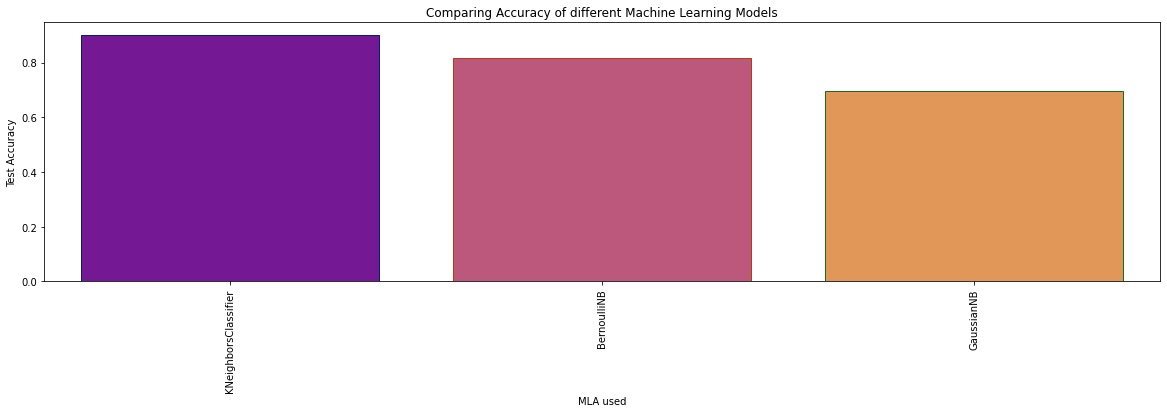

In [ ]:
MLA = [
        # GLM : Generalized Linear Model (GLM)
        # GLMs are a class of regression models that extend the linear regression model

        # Ensemble Methods: Ensemble classification methods are machine learning techniques that combine the
        # predictions of multiple individual models to produce a final prediction.


        # Navies Bayes
        naive_bayes.BernoulliNB(),
        naive_bayes.GaussianNB(),

        # Nearest Neighbor
        neighbors.KNeighborsClassifier(),
    ]

MLA_columns = []
MLA_compare = pd.DataFrame(columns=MLA_columns)

row_index = 0
for alg in MLA:
    predicted = alg.fit(x_train, y_train).predict(x_test)
    print (alg)
    print(round(alg.score(x_test, y_test), 4))
 
    fp, tp, th = roc_curve(y_test, predicted)
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA used'] = MLA_name
    MLA_compare.loc[row_index, 'Train Accuracy'] = round(alg.score(x_train, y_train), 4)
    MLA_compare.loc[row_index, 'Test Accuracy'] = round(alg.score(x_test, y_test), 4)
    MLA_compare.loc[row_index, 'Precission'] = precision_score(y_test, predicted, zero_division=0)
    MLA_compare.loc[row_index, 'Recall'] = recall_score(y_test, predicted, zero_division=0)
    MLA_compare.loc[row_index, 'AUC'] = auc(fp, tp)

    row_index += 1

MLA_compare.sort_values(by=['Test Accuracy'], ascending=False, inplace=True)

    # Creating plot to show the test accuracy

plt.subplots(figsize=(20, 8))
sns.barplot(x="MLA used", y="Test Accuracy", data=MLA_compare, palette='plasma',
                edgecolor=sns.color_palette('dark', 7))
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.5)
plt.subplots_adjust(top=0.95)
plt.title('Comparing Accuracy of different Machine Learning Models')
plt.draw()

In [ ]:
rf  = RandomForestClassifier(max_depth=1, random_state=0)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
accuracy_score(y_test, y_pred)


0.7873331263582738

In [ ]:
clf = SVC()
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
print(accuracy_score(y_test,y_pred))

0.6904687985097796


In [ ]:
model = Sequential()
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train,
                   validation_data=(x_test, y_test),
                   epochs=50,
                   batch_size=32,
                   verbose=1)

Epoch 1/50


2023-05-04 12:42:26.764757: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1208/1208 [==============================] - 2s 1ms/step - loss: 1236.0255 - accuracy: 0.5914 - val_loss: 613.0622 - val_accuracy: 0.6500
Epoch 2/50
1208/1208 [==============================] - 1s 888us/step - loss: 428.6822 - accuracy: 0.6414 - val_loss: 432.6922 - val_accuracy: 0.5046
Epoch 3/50
1208/1208 [==============================] - 1s 867us/step - loss: 214.4494 - accuracy: 0.6663 - val_loss: 39.9205 - val_accuracy: 0.5601
Epoch 4/50
1208/1208 [==============================] - 1s 865us/step - loss: 96.8753 - accuracy: 0.6865 - val_loss: 116.1839 - val_accuracy: 0.5093
Epoch 5/50
1208/1208 [==============================] - 1s 885us/step - loss: 69.1367 - accuracy: 0.6882 - val_loss: 78.8772 - val_accuracy: 0.5281
Epoch 6/50
1208/1208 [==============================] - 1s 876us/step - loss: 31.5662 - accuracy: 0.7038 - val_loss: 2.0661 - val_accuracy: 0.7993
Epoch 7/50
1208/1208 [==============================] - 1s 833us/step - loss: 18.0681 - accuracy: 0.7031 - val_loss: 9.

In [ ]:
model.evaluate(x_test, y_test)[1]

302/302 [==============================] - 0s 426us/step - loss: 0.5581 - accuracy: 0.6630


0.6630446314811707

In [ ]:
_, accuracy = model.evaluate(x_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

302/302 [==============================] - 0s 428us/step - loss: 0.5581 - accuracy: 0.6630
Accuracy: 66.30


In [ ]:
predictions = (model.predict(x_test)).astype(int)

302/302 [==============================] - 0s 383us/step


## Trying LTSM

In [66]:
players_df = pd.read_csv("data/cleaned_merged_seasons.csv", low_memory=False)
players_list_df = players_df[['name' , 'total_points', 'GW', 'season_x']]
top_player = players_df.sort_values('selected', ascending=False).drop_duplicates(['name']).iloc[0:1]
players_df = players_df[players_df['name'].isin(top_player['name'])]
players_df

,Unnamed: 0,season_x,name,position,team_x,assists,bonus,bps,clean_sheets,creativity,...,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW
101562,101562,2022-23,Erling Haaland,FWD,Man City,0,3,48,1,4.8,...,0.0,73.0,13,0,0,0,115,False,0,1.0
102136,102136,2022-23,Erling Haaland,FWD,Man City,1,0,16,1,13.3,...,4.0,23.0,5,1113937,1143813,29876,116,True,0,2.0
102718,102718,2022-23,Erling Haaland,FWD,Man City,0,0,28,0,11.9,...,3.0,70.0,6,227317,368864,141547,117,False,0,3.0
103311,103311,2022-23,Erling Haaland,FWD,Man City,0,3,73,0,1.3,...,4.0,105.0,17,99625,231905,132280,117,True,0,4.0
103913,103913,2022-23,Erling Haaland,FWD,Man City,0,3,81,1,0.8,...,6.0,91.0,17,624916,675165,50249,118,True,0,5.0
104521,104521,2022-23,Erling Haaland,FWD,Man City,0,3,32,0,14.8,...,1.0,79.0,9,782279,802502,20223,119,False,0,6.0
105118,105118,2022-23,Erling Haaland,FWD,Man City,0,0,29,1,3.4,...,0.0,22.0,6,135042,142869,7827,120,False,0,8.0
105587,105587,2022-23,Erling Haaland,FWD,Man City,2,3,102,0,45.5,...,6.0,124.0,23,94190,126753,32563,121,True,0,9.0
106226,106226,2022-23,Erling Haaland,FWD,Man City,0,0,23,1,21.0,...,4.0,73.0,6,272643,277921,5278,122,True,0,10.0
106867,106867,2022-23,Erling Haaland,FWD,Man City,0,0,-2,0,13.9,...,1.0,122.0,2,40632,72323,31691,122,False,0,11.0


In [67]:
players_df['kickoff_time'] = players_df['kickoff_time'].str.slice(0, 10)
players_df

,Unnamed: 0,season_x,name,position,team_x,assists,bonus,bps,clean_sheets,creativity,...,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW
101562,101562,2022-23,Erling Haaland,FWD,Man City,0,3,48,1,4.8,...,0.0,73.0,13,0,0,0,115,False,0,1.0
102136,102136,2022-23,Erling Haaland,FWD,Man City,1,0,16,1,13.3,...,4.0,23.0,5,1113937,1143813,29876,116,True,0,2.0
102718,102718,2022-23,Erling Haaland,FWD,Man City,0,0,28,0,11.9,...,3.0,70.0,6,227317,368864,141547,117,False,0,3.0
103311,103311,2022-23,Erling Haaland,FWD,Man City,0,3,73,0,1.3,...,4.0,105.0,17,99625,231905,132280,117,True,0,4.0
103913,103913,2022-23,Erling Haaland,FWD,Man City,0,3,81,1,0.8,...,6.0,91.0,17,624916,675165,50249,118,True,0,5.0
104521,104521,2022-23,Erling Haaland,FWD,Man City,0,3,32,0,14.8,...,1.0,79.0,9,782279,802502,20223,119,False,0,6.0
105118,105118,2022-23,Erling Haaland,FWD,Man City,0,0,29,1,3.4,...,0.0,22.0,6,135042,142869,7827,120,False,0,8.0
105587,105587,2022-23,Erling Haaland,FWD,Man City,2,3,102,0,45.5,...,6.0,124.0,23,94190,126753,32563,121,True,0,9.0
106226,106226,2022-23,Erling Haaland,FWD,Man City,0,0,23,1,21.0,...,4.0,73.0,6,272643,277921,5278,122,True,0,10.0
106867,106867,2022-23,Erling Haaland,FWD,Man City,0,0,-2,0,13.9,...,1.0,122.0,2,40632,72323,31691,122,False,0,11.0


In [68]:
players_df["kickoff_time"] = pd.to_datetime(players_df["kickoff_time"])
players_df

,Unnamed: 0,season_x,name,position,team_x,assists,bonus,bps,clean_sheets,creativity,...,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW
101562,101562,2022-23,Erling Haaland,FWD,Man City,0,3,48,1,4.8,...,0.0,73.0,13,0,0,0,115,False,0,1.0
102136,102136,2022-23,Erling Haaland,FWD,Man City,1,0,16,1,13.3,...,4.0,23.0,5,1113937,1143813,29876,116,True,0,2.0
102718,102718,2022-23,Erling Haaland,FWD,Man City,0,0,28,0,11.9,...,3.0,70.0,6,227317,368864,141547,117,False,0,3.0
103311,103311,2022-23,Erling Haaland,FWD,Man City,0,3,73,0,1.3,...,4.0,105.0,17,99625,231905,132280,117,True,0,4.0
103913,103913,2022-23,Erling Haaland,FWD,Man City,0,3,81,1,0.8,...,6.0,91.0,17,624916,675165,50249,118,True,0,5.0
104521,104521,2022-23,Erling Haaland,FWD,Man City,0,3,32,0,14.8,...,1.0,79.0,9,782279,802502,20223,119,False,0,6.0
105118,105118,2022-23,Erling Haaland,FWD,Man City,0,0,29,1,3.4,...,0.0,22.0,6,135042,142869,7827,120,False,0,8.0
105587,105587,2022-23,Erling Haaland,FWD,Man City,2,3,102,0,45.5,...,6.0,124.0,23,94190,126753,32563,121,True,0,9.0
106226,106226,2022-23,Erling Haaland,FWD,Man City,0,0,23,1,21.0,...,4.0,73.0,6,272643,277921,5278,122,True,0,10.0
106867,106867,2022-23,Erling Haaland,FWD,Man City,0,0,-2,0,13.9,...,1.0,122.0,2,40632,72323,31691,122,False,0,11.0


In [69]:
players_df = players_df.set_index('kickoff_time')
players_df.sort_index()
players_df

,Unnamed: 0,season_x,name,position,team_x,assists,bonus,bps,clean_sheets,creativity,...,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW
kickoff_time,,,,,,,,,,,,,,,,,,,,,
2022-08-07,101562,2022-23,Erling Haaland,FWD,Man City,0,3,48,1,4.8,...,0.0,73.0,13,0,0,0,115,False,0,1.0
2022-08-13,102136,2022-23,Erling Haaland,FWD,Man City,1,0,16,1,13.3,...,4.0,23.0,5,1113937,1143813,29876,116,True,0,2.0
2022-08-21,102718,2022-23,Erling Haaland,FWD,Man City,0,0,28,0,11.9,...,3.0,70.0,6,227317,368864,141547,117,False,0,3.0
2022-08-27,103311,2022-23,Erling Haaland,FWD,Man City,0,3,73,0,1.3,...,4.0,105.0,17,99625,231905,132280,117,True,0,4.0
2022-08-31,103913,2022-23,Erling Haaland,FWD,Man City,0,3,81,1,0.8,...,6.0,91.0,17,624916,675165,50249,118,True,0,5.0
2022-09-03,104521,2022-23,Erling Haaland,FWD,Man City,0,3,32,0,14.8,...,1.0,79.0,9,782279,802502,20223,119,False,0,6.0
2022-09-17,105118,2022-23,Erling Haaland,FWD,Man City,0,0,29,1,3.4,...,0.0,22.0,6,135042,142869,7827,120,False,0,8.0
2022-10-02,105587,2022-23,Erling Haaland,FWD,Man City,2,3,102,0,45.5,...,6.0,124.0,23,94190,126753,32563,121,True,0,9.0
2022-10-08,106226,2022-23,Erling Haaland,FWD,Man City,0,0,23,1,21.0,...,4.0,73.0,6,272643,277921,5278,122,True,0,10.0


In [70]:
players_df = players_df[['total_points']]
players_df

In [72]:
#fillna
for column in players_df.columns:
    players_df[column] = players_df[column].fillna(0) #using '0' to fill na.
players_df

/var/folders/jc/p7myh4c15592hx_1frgfvyl80000gn/T/ipykernel_13949/565270803.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players_df[column] = players_df[column].fillna(0) #using '0' to fill na.


,total_points
kickoff_time,
2022-08-07,13
2022-08-13,5
2022-08-21,6
2022-08-27,17
2022-08-31,17
2022-09-03,9
2022-09-17,6
2022-10-02,23
2022-10-08,6


In [78]:
def series_to_supervised(data, n_in, n_out, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = data
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

reframed = series_to_supervised(players_df, 10, 1)
reframed


,var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
kickoff_time,,,,,,,,,,,
2022-10-22,13.0,5.0,6.0,17.0,17.0,9.0,6.0,23.0,6.0,2.0,13
2022-10-29,5.0,6.0,17.0,17.0,9.0,6.0,23.0,6.0,2.0,13.0,0
2022-11-05,6.0,17.0,17.0,9.0,6.0,23.0,6.0,2.0,13.0,0.0,5
2022-11-12,17.0,17.0,9.0,6.0,23.0,6.0,2.0,13.0,0.0,5.0,1
2022-12-28,17.0,9.0,6.0,23.0,6.0,2.0,13.0,0.0,5.0,1.0,13
2022-12-31,9.0,6.0,23.0,6.0,2.0,13.0,0.0,5.0,1.0,13.0,6
2022-12-31,6.0,23.0,6.0,2.0,13.0,0.0,5.0,1.0,13.0,6.0,6
2023-01-05,23.0,6.0,2.0,13.0,0.0,5.0,1.0,13.0,6.0,6.0,2
2023-01-14,6.0,2.0,13.0,0.0,5.0,1.0,13.0,6.0,6.0,2.0,2


In [74]:
values = reframed.values
n_train_matchweek = int(len(values) * 0.7)
train = values[:n_train_matchweek, :]
test = values[n_train_matchweek:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(11, 1, 10) (11,) (5, 1, 10) (5,)


2023-05-04 13:35:04.733070: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-04 13:35:04.734303: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Epoch 1/50


2023-05-04 13:35:05.597015: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-04 13:35:06.400188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-04 13:35:06.565852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-04 13:35:08.040594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 - 4s - loss: 6.5386 - val_loss: 4.6846 - 4s/epoch - 4s/step


2023-05-04 13:35:09.201786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-04 13:35:09.248222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 2/50
1/1 - 0s - loss: 6.4562 - val_loss: 4.6142 - 38ms/epoch - 38ms/step
Epoch 3/50
1/1 - 0s - loss: 6.3760 - val_loss: 4.5391 - 38ms/epoch - 38ms/step
Epoch 4/50
1/1 - 0s - loss: 6.2940 - val_loss: 4.4647 - 29ms/epoch - 29ms/step
Epoch 5/50
1/1 - 0s - loss: 6.2139 - val_loss: 4.3907 - 32ms/epoch - 32ms/step
Epoch 6/50
1/1 - 0s - loss: 6.1335 - val_loss: 4.3170 - 28ms/epoch - 28ms/step
Epoch 7/50
1/1 - 0s - loss: 6.0531 - val_loss: 4.2436 - 39ms/epoch - 39ms/step
Epoch 8/50
1/1 - 0s - loss: 5.9730 - val_loss: 4.1706 - 29ms/epoch - 29ms/step
Epoch 9/50
1/1 - 0s - loss: 5.8933 - val_loss: 4.0979 - 31ms/epoch - 31ms/step
Epoch 10/50
1/1 - 0s - loss: 5.8139 - val_loss: 4.0258 - 31ms/epoch - 31ms/step
Epoch 11/50
1/1 - 0s - loss: 5.7349 - val_loss: 3.9542 - 31ms/epoch - 31ms/step
Epoch 12/50
1/1 - 0s - loss: 5.6562 - val_loss: 3.8832 - 33ms/epoch - 33ms/step
Epoch 13/50
1/1 - 0s - loss: 5.5777 - val_loss: 3.8127 - 32ms/epoch - 32ms/step
Epoch 14/50
1/1 - 0s - loss: 5.4991 - val_loss: 

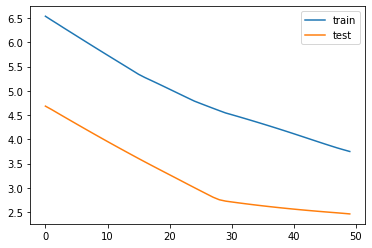

In [79]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=24, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [80]:
# calculate RMSE
y = model.predict(test_X)
rmse = np.sqrt(mean_squared_error(y, test_y))
print('Test RMSE: %.3f' % rmse)


1/1 [==============================] - 0s 240ms/step
Test RMSE: 3.189


2023-05-04 13:35:13.697092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-04 13:35:13.736226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
